Data fields
- TripType - a categorical id representing the type of shopping trip the customer made. This is the ground truth that you are predicting. TripType_999 is an "other" category.
- VisitNumber - an id corresponding to a single trip by a single customer
- Weekday - the weekday of the trip
- Upc - the UPC number of the product purchased
    - UPCs are Universal Product Code that consists of the company code, a product number and a checksum.
- ScanCount - the number of the given item that was purchased. A negative value indicates a product return.
- DepartmentDescription - a high-level description of the item's department

- FinelineNumber - a more refined category for each of the products, created by Walmart

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

from joblib import Parallel, delayed

__AUTHOR__ = 'Kirgsn'

class Reducer:
    """
    Class that takes a dict of increasingly big numpy datatypes to transform
    the data of a pandas dataframe to in order to save memory usage.
    """
    memory_scale_factor = 1024**2  # memory in MB

    def __init__(self, conv_table=None):
        """
        :param conv_table: dict with np.dtypes-strings as keys
        """
        if conv_table is None:
            self.conversion_table = \
                {'int': [np.int8, np.int16, np.int32, np.int64],
                 'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
                 'float': [np.float16, np.float32, ]}
        else:
            self.conversion_table = conv_table

    def _type_candidates(self, k):
        for c in self.conversion_table[k]:
            i = np.iinfo(c) if 'int' in k else np.finfo(c)
            yield c, i

    def reduce(self, df, verbose=False):
        """Takes a dataframe and returns it with all data transformed to the
        smallest necessary types.

        :param df: pandas dataframe
        :param verbose: If True, outputs more information
        :return: pandas dataframe with reduced data types
        """
        ret_list = Parallel(n_jobs=-1)(delayed(self._reduce)
                                                (df[c], c, verbose) for c in
                                                df.columns)

        return pd.concat(ret_list, axis=1)

    def _reduce(self, s, colname, verbose):

        # skip NaNs
        if s.isnull().any():
            if verbose:
                print(colname, 'has NaNs - Skip..')
            return s

        # detect kind of type
        coltype = s.dtype
        if np.issubdtype(coltype, np.integer):
            conv_key = 'int' if s.min() < 0 else 'uint'
        elif np.issubdtype(coltype, np.floating):
            conv_key = 'float'
        else:
            if verbose:
                print(colname, 'is', coltype, '- Skip..')
            print(colname, 'is', coltype, '- Skip..')
            return s

        # find right candidate
        for cand, cand_info in self._type_candidates(conv_key):
            if s.max() <= cand_info.max and s.min() >= cand_info.min:

                if verbose:
                    print('convert', colname, 'to', str(cand))
                return s.astype(cand)

        # reaching this code is bad. Probably there are inf, or other high numbs
        print(("WARNING: {} " 
               "doesn't fit the grid with \nmax: {} "
               "and \nmin: {}").format(colname, s.max(), s.min()))
        print('Dropping it..')
        
import pandas as pd

df = pd.read_csv("train.csv")
reducer = Reducer()
df = reducer.reduce(df)

ls = ['TripType', 'Weekday', 'Upc', 'DepartmentDescription', 'FinelineNumber']
def to_cat(ls=ls):
    for l in ls:
        df[l] = df[l].astype("category")
to_cat()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null category
VisitNumber              647054 non-null uint32
Weekday                  647054 non-null category
Upc                      642925 non-null category
ScanCount                647054 non-null int8
DepartmentDescription    645693 non-null category
FinelineNumber           642925 non-null category
dtypes: category(5), int8(1), uint32(1)
memory usage: 12.1 MB


In [40]:
df.dtypes.reset_index().rename(columns={0:'dtype'}).set_index('index')

,dtype
index,
TripType,category
VisitNumber,uint32
Weekday,category
Upc,category
ScanCount,int8
DepartmentDescription,category
FinelineNumber,category


## unique val
- VisitNumber은 고객 고유 번호(ID)
- Department의 세부 분류 FinelineNumber 분류 확인 필요

In [46]:
df.nunique().reset_index().rename(columns={0:'uniuqe val count'}).set_index('index')

,uniuqe val count
index,
TripType,38
VisitNumber,95674
Weekday,7
Upc,97714
ScanCount,39
DepartmentDescription,68
FinelineNumber,5195


### ScanCount
- 1회에 얼마나 구매했는지는 모름
- 고유식별ID에 따른 scancount가 같을 때, FinNum, Department 같은지 확인
- 같다면 동일한 것으로 간주하고 scancount만 +해주면 됌

In [56]:
df['ScanCount'].value_counts().reset_index().sort_values('index').set_index('index')

,ScanCount
index,
-12,1
-10,1
-9,2
-7,1
-6,10
-5,16
-4,76
-3,143
-2,814


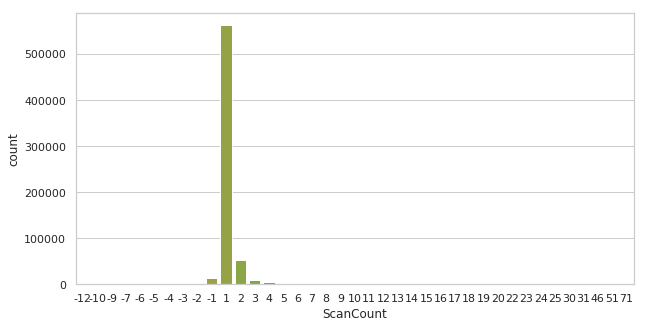

In [10]:
plt.figure(figsize=(10,5))
sns.countplot(x='ScanCount', data=df)

---

In [3]:
import lightgbm
mod = lightgbm.LGBMClassifier(n_estimators=100, max_depth=1, random_state=99)

In [4]:
X = df[df.columns[1:]]
y = df['TripType']
res = mod.fit(X, y)

In [17]:
res.get_params

<bound method LGBMModel.get_params of LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=99, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)>

In [8]:
res.feature_importances_

array([  98,   45,  689,   76, 1607, 1285])

In [18]:
res.n_classes_

38

In [19]:
res.n_features_

6

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y, res.predict(X)))

/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           3       0.88      0.82      0.85      6827
           4       0.35      0.24      0.28       901
           5       0.44      0.52      0.47     13836
           6       0.50      0.28      0.36      3405
           7       0.39      0.15      0.22     23199
           8       0.47      0.03      0.06     22844
           9       0.24      0.08      0.12     16820
          12       0.36      0.09      0.15      2108
          14       0.50      0.31      0.39        35
          15       0.29      0.36      0.32      7147
          18       0.25      0.36      0.29      2977
          19       0.55      0.33      0.42      1188
          20       0.32      0.51      0.40      3116
          21       0.24      0.62      0.34      4032
          22       0.40      0.35      0.37      3592
          23       0.70      0.40      0.51       325
          24       0.34      0.45      0.39     18015
          25       0.44    

/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/henry/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Visitnumber

In [29]:
print("Unique Visitnumber:" ,len(df['VisitNumber'].unique()))

Unique Visitnumber: 95674


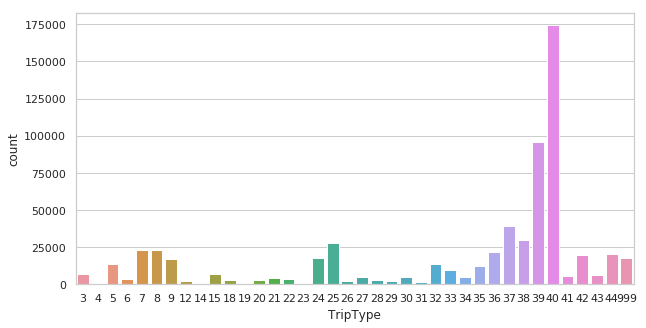

In [9]:
plt.figure(figsize=(10,5))
sns.countplot(x='TripType', data=dataset)
plt.show()

# ScanCount

In [38]:
idx, cnt = np.unique(df['ScanCount'].values, return_counts=True)
pd.DataFrame(cnt, idx, columns=['cnt']).sort_values('cnt', ascending=False).T

,1,2,-1,3,4,5,6,-2,8,7,...,-9,22,31,46,51,-12,30,-10,-7,71
cnt,561489,53002,14394,9445,4536,1380,866,814,246,228,...,2,2,1,1,1,1,1,1,1,1


In [ ]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='Weekday', data=data)
for p in ax.patches:
    height=p.get_height()
    percent = (height*100)/totalrows
    ax.text((p.get_x() + p.get_width()/2), p.get_height()+5, '{:1.2f} %'.format(percent), ha='center')

In [7]:
import pandas as pd

dataset = pd.read_csv("train.csv")
reducer = Reducer()
dataset = reducer.reduce(dataset)

In [3]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
TripType                 647054 non-null int64
VisitNumber              647054 non-null int64
Weekday                  647054 non-null object
Upc                      642925 non-null float64
ScanCount                647054 non-null int64
DepartmentDescription    645693 non-null object
FinelineNumber           642925 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653646 entries, 0 to 653645
Data columns (total 6 columns):
VisitNumber              653646 non-null int64
Weekday                  653646 non-null object
Upc                      649660 non-null float64
ScanCount                653646 non-null int64
DepartmentDescription    652318 non-null object
FinelineNumber           649660 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 29.9+ MB


(None, None)

In [4]:
len(df['Upc'].unique())

97715

In [27]:
df.sample(5)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
325474,35,97585,Saturday,8.348780e+10,2,DSD GROCERY,3855.0
217549,40,64312,Monday,4.045000e+03,1,PRODUCE,3004.0
14679,8,4786,Friday,4.142680e+09,1,HOUSEHOLD PAPER GOODS,5560.0
472660,25,140860,Saturday,8.046919e+10,1,SWIMWEAR/OUTERWEAR,134.0
39825,38,11818,Saturday,4.135000e+03,1,PRODUCE,1214.0


In [28]:
df_test.sample(5)

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
176609,53553,Saturday,4.400003e+09,1,DSD GROCERY,2758.0
600654,177952,Saturday,8.853063e+10,1,BOYS WEAR,4351.0
232629,69183,Monday,4.138309e+09,2,DAIRY,1505.0
83982,24144,Monday,8.265700e+09,1,DSD GROCERY,9214.0
29079,9446,Saturday,7.225004e+09,1,COMM BREAD,3702.0


In [34]:
#Filnline기준
df.sort_values('FinelineNumber')[10000:10000+10]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
630312,25,187294,Sunday,4.460031e+09,1,LAWN AND GARDEN,31.0
500505,39,148329,Sunday,4.460031e+09,1,LAWN AND GARDEN,31.0
41472,40,12302,Saturday,4.460031e+09,1,LAWN AND GARDEN,31.0
3306,9,1319,Friday,4.460031e+09,1,LAWN AND GARDEN,31.0
577229,40,172005,Thursday,4.460031e+09,1,LAWN AND GARDEN,31.0
198389,39,59007,Sunday,3.700089e+09,1,PERSONAL CARE,31.0
299396,40,90254,Friday,4.460031e+09,1,LAWN AND GARDEN,31.0
263249,39,78439,Wednesday,4.460031e+09,1,LAWN AND GARDEN,31.0
346781,36,102928,Sunday,3.700089e+09,1,PERSONAL CARE,31.0
168938,36,51206,Saturday,7.940033e+09,1,PERSONAL CARE,31.0


In [35]:
# VisitNumber
df.sort_values('VisitNumber')[10000:10000+10]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
9976,40,3383,Friday,7.874237e+09,1,GROCERY DRY GOODS,3556.0
9977,40,3383,Friday,2.265570e+09,2,MEAT - FRESH & FROZEN,6160.0
9978,40,3383,Friday,4.900001e+09,1,DSD GROCERY,9538.0
9979,40,3383,Friday,3.940002e+09,1,GROCERY DRY GOODS,2837.0
9980,40,3383,Friday,7.874243e+09,1,FROZEN FOODS,1801.0
9981,40,3383,Friday,2.500005e+09,1,DAIRY,1404.0
9982,40,3383,Friday,8.312000e+09,2,"LIQUOR,WINE,BEER",2201.0
9973,40,3383,Friday,1.530043e+09,3,GROCERY DRY GOODS,3804.0
10008,19,3386,Friday,8.861118e+10,1,ELECTRONICS,1264.0
10010,8,3391,Friday,2.015450e+10,1,SERVICE DELI,8001.0


In [36]:
# ScanCount
df.sort_values('ScanCount').tail(10)

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
442483,40,132043,Friday,5.000004e+09,24,PETS AND SUPPLIES,1436.0
240931,38,71308,Tuesday,4.178900e+09,24,GROCERY DRY GOODS,3105.0
384372,33,113049,Tuesday,7.874211e+09,25,HOUSEHOLD PAPER GOODS,6030.0
623307,4,185536,Sunday,8.307801e+09,25,PHARMACY OTC,1181.0
187171,34,55853,Saturday,5.000043e+09,25,PETS AND SUPPLIES,1436.0
23461,7,7379,Saturday,7.874205e+09,30,FROZEN FOODS,1752.0
237383,36,70115,Tuesday,3.004167e+10,31,PERSONAL CARE,402.0
163238,38,49651,Saturday,4.178900e+09,46,GROCERY DRY GOODS,3105.0
274806,40,82067,Thursday,6.053882e+10,51,SHOES,8960.0
478028,32,142397,Saturday,4.178900e+09,71,GROCERY DRY GOODS,3120.0


In [21]:
def unique(df=df):
    col = df.columns
    for i in range(len(col)):
        print("{}: ".format(col[i]), df[col[i]].unique())
        print("len: ", len(df[col[i]].unique()))
        print()
unique(df)

TripType:  [999  30  26   8  35  41  21   6  42   7   9  39  25  38  15  36  20  37
  32  40   5   3   4  24  33  43  31  27  34  18  29  44  19  23  22  28
  14  12]
len:  38

VisitNumber:  [     5      7      8 ... 191345 191346 191347]
len:  95674

Weekday:  ['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']
len:  7

Upc:  [6.81131529e+10 6.05388160e+10 7.41081110e+09 ... 8.85306278e+10
 8.87439527e+10 5.44000008e+09]
len:  97715

ScanCount:  [ -1   1   2   3   5   6   4  14  -2   9   7  10   8  -3  -5  11  16  -4
  13  15  30  -6  12  20 -12  19  46  23  -7  22  25  24  31  -9  51  17
  18  71 -10]
len:  39

DepartmentDescription:  ['FINANCIAL SERVICES' 'SHOES' 'PERSONAL CARE' 'PAINT AND ACCESSORIES'
 'DSD GROCERY' 'MEAT - FRESH & FROZEN' 'DAIRY' 'PETS AND SUPPLIES'
 'HOUSEHOLD CHEMICALS/SUPP' nan 'IMPULSE MERCHANDISE' 'PRODUCE'
 'CANDY, TOBACCO, COOKIES' 'GROCERY DRY GOODS' 'BOYS WEAR'
 'FABRICS AND CRAFTS' 'JEWELRY AND SUNGLASSES' 'MENS WEAR' 'ACCESSORIES'
 

In [ ]:
Returned = grpwall.merge(pd.DataFrame({'ItemReturned':grpwall.ScanCount <= 0}),\left_index = True, right_index = True)


Returned['RealSC'] = Returned.ScanCount

Returned['RealSC'].ix[Returned.ItemReturned]=0



containsReturned = Returned.merge(pd.DataFrame\

({'ContainsReturned':Returned.groupby('VisitNumber').sum().ItemReturned>=1}),\

left_on=['VisitNumber'], right_index=True)



NumberReturned = containsReturned.merge(pd.DataFrame\

({'NumReturned':containsReturned.groupby('VisitNumber').sum().ItemReturned}),\

left_on=['VisitNumber'], right_index=True)



nUnqItems = NumberReturned.merge(pd.DataFrame\

({'itemcount':NumberReturned.groupby('VisitNumber').size()}),\

left_on=['VisitNumber'], right_index=True)



addFeats = nUnqItems.merge(pd.DataFrame\

({'totalcount':nUnqItems.groupby('VisitNumber').sum().RealSC}),\

left_on=['VisitNumber'], right_index=True)



grpUpc = pd.DataFrame({'percentTrip':addFeats.groupby\

(['VisitNumber','Upc']).size()/addFeats.groupby(['VisitNumber']).size()})

prcntTrip = addFeats.merge(grpUpc, left_on=['VisitNumber', 'Upc'], right_index = True)



grpLineItem = pd.DataFrame({'percentLineTrip':addFeats.groupby\

(['VisitNumber','FinelineNumber']).size()/addFeats.groupby(['VisitNumber']).size()})

prcntTripII = prcntTrip.merge(grpLineItem, left_on=['VisitNumber', 'FinelineNumber'], right_index = True)



grpDepartItem = pd.DataFrame({'percentDepartTrip':addFeats.groupby\

(['VisitNumber','DepartmentDescription']).size()/addFeats.groupby(['VisitNumber']).size()})

prcntTripIII = prcntTripII.merge(grpDepartItem,\

left_on=['VisitNumber', 'DepartmentDescription'], right_index = True)

In [7]:
df.columns

Index(['TripType', 'VisitNumber', 'Weekday', 'Upc', 'ScanCount',
       'DepartmentDescription', 'FinelineNumber'],
      dtype='object')

In [ ]:
trip_byscancount = pd.crosstab(scancount['ScanCount'], scancount['TripType'])

In [46]:
Returned = df.merge(pd.DataFrame({'ItemReturned':df.ScanCount <= 0}),left_index = True, right_index = True)
Returned[:5]

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,ItemReturned
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,True
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,False
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,False
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,False
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,False


# FineLine vs triptype

In [2]:
df_t_f_c = df[['FinelineNumber', 'TripType']].groupby(['TripType', 'FinelineNumber']).size().reset_index().rename(columns={0:'count'})
cond1 = df_t_f_c['count'] > 0
cond2 = df_t_f_c['FinelineNumber'] != 0
df_t_f_c = df_t_f_c[cond1&cond2].sort_values('count', ascending=False)
# df_t_f_c = df_t_f_c[cond1&cond2].pivot(index='FinelineNumber', columns='TripType', values='count')
# df_t_f_c
# plt.figure(figsize=(50,50))
# sns.heatmap(df_t_f_c.fillna(-1))
# plt.show()

In [ ]:
temp = data.drop_duplicates(subset)

# look into VsitNumber 8

In [58]:
v8 = df[df['VisitNumber'] == 8]
v8.sort_values('FinelineNumber')

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
25,26,8,Friday,NaN,1,NaN,NaN
13,26,8,Friday,2.236760e+09,1,PAINT AND ACCESSORIES,7.0
21,26,8,Friday,7.874205e+09,1,HOUSEHOLD CHEMICALS/SUPP,707.0
24,26,8,Friday,3.270011e+09,3,PETS AND SUPPLIES,1001.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
5,26,8,Friday,2.006619e+09,2,PAINT AND ACCESSORIES,1017.0
6,26,8,Friday,2.006614e+09,1,PAINT AND ACCESSORIES,1017.0
20,26,8,Friday,7.245040e+10,2,PAINT AND ACCESSORIES,1018.0
17,26,8,Friday,7.245041e+10,1,PAINT AND ACCESSORIES,1028.0
18,26,8,Friday,2.554150e+10,2,DAIRY,1305.0


### TripType 하나에 영향을 줘야 맞음 -> 그런데 데이터는 25개 생성 -> TripType 갯수 왜곡됨


In [29]:
v8.FinelineNumber.value_counts()[:20]

3565.0    3
1017.0    3
3504.0    2
4415.0    2
2802.0    1
1018.0    1
3300.0    1
2801.0    1
4606.0    1
6009.0    1
4501.0    1
707.0     1
1028.0    1
1305.0    1
7.0       1
1001.0    1
2616.0    0
2617.0    0
2615.0    0
2614.0    0
Name: FinelineNumber, dtype: int64

### 왜 TripType 26으로 분류?

In [10]:
v8.groupby('')

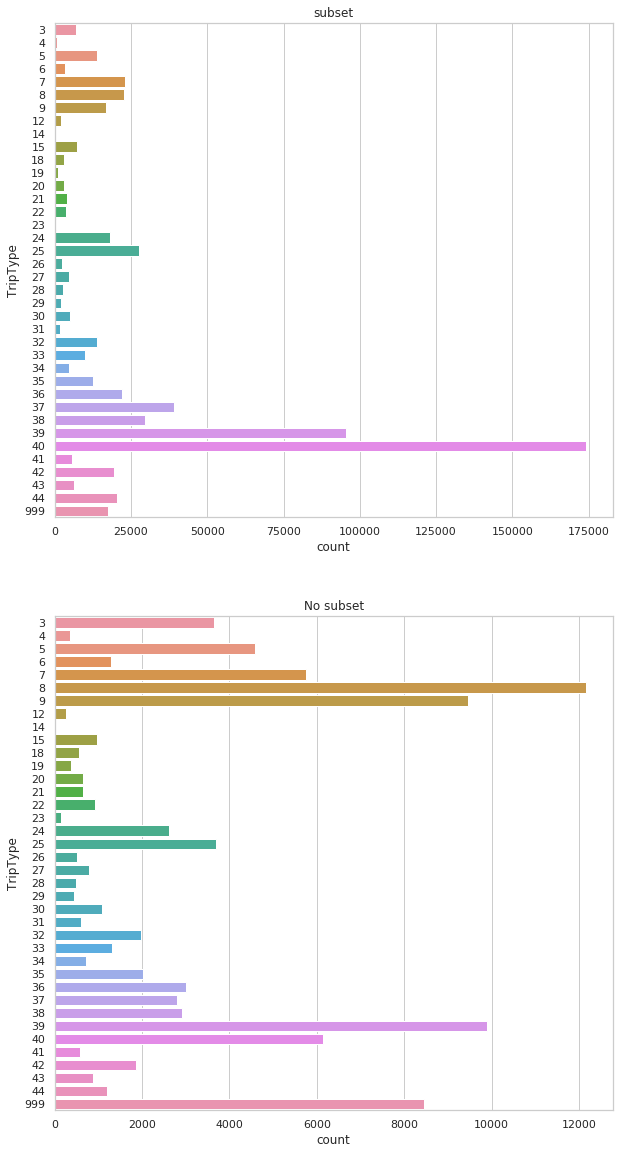

In [34]:
plt.figure(figsize=(10,20))

plt.subplot(211)
plt.title('subset')
sns.countplot(y='TripType', data=df,)

plt.subplot(212)
plt.title('No subset')
sns.countplot(y='TripType', data=df.drop_duplicates('VisitNumber'),)

plt.show()

In [ ]:
# 각 triptype 별 finline bar plot
cond3 = df_t_f_c['TripType'] == 40
sns.barplot('FinelineNumber', 'count', data=df_t_f_c[cond3])
plt.show()

KeyboardInterrupt: 

In [70]:
# visit number - FinelineNumber - Triptype관계
# Fineline -> Triptype에 어떤 영향?
## Fineline
# temp = df[['VisitNumber', 'TripType']]
# temp = temp.drop_duplicates(subset=['VisitNumber'])

# df_f_v_c = df[['VisitNumber', 'FinelineNumber']].\
# groupby(['FinelineNumber', 'VisitNumber']).\
# size().reset_index().sort_values(0, ascending=False).\
# rename(columns={0:'count'})

# df_f_v_c_t = pd.merge(df_f_v_c, temp, how='inner', on=['VisitNumber'])
# df_f_v_c_t[:5]

,FinelineNumber,VisitNumber,count,TripType
0,4607.0,120789,24,35
1,1901.0,149892,21,40
2,6504.0,149892,4,40
3,4302.0,149892,1,40
4,9704.0,149892,1,40


In [87]:
cond = df_f_v_c_t['TripType'] == 35
df_f_v_c_t[cond]

,FinelineNumber,VisitNumber,count,TripType
0,4607.0,120789,24,35
39,3301.0,109281,16,35
40,5602.0,109281,1,35
188,145.0,31361,14,35
189,3232.0,31361,2,35
190,3561.0,31361,2,35
191,807.0,31361,1,35
192,601.0,31361,1,35
193,87.0,31361,1,35
694,4606.0,73882,11,35
